# Data Science Salary Project 

<font size = '4'>In this project, we will create a salary estimator for data scientist related jobs.<font>

In [110]:
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException, StaleElementReferenceException
from selenium import webdriver
import time
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

## Data Collection
<font size = '4'>Create a Web Scraper to scrape jobs data from Glassdoor.com<font>

In [140]:
def get_jobs(keyword, num_jobs, verbose, path, slp_time):
    
    #Initializing the webdriver
    options = webdriver.ChromeOptions()
     
    driver = webdriver.Chrome(executable_path=path, options=options)
    driver.set_window_size(1120, 1000)

    url = "https://www.glassdoor.ca/Job/jobs.htm?suggestCount=0&suggestChosen=false&clickSource=searchBtn&typedKeyword="+keyword+"&sc.keyword="+keyword+"&locT=&locId=&jobType="
   
    driver.get(url)
    jobs = []

    while len(jobs) < num_jobs:  #If true, should be still looking for new jobs.

        time.sleep(slp_time)      

        #Test for the "Sign Up" prompt and get rid of it.
        try:
            driver.find_element_by_class_name("selected").click()
        except ElementClickInterceptedException:
            pass

        time.sleep(.1)

        try:
            driver.find_element_by_css_selector('[alt="Close"]').click() #clicking X to close.
        except NoSuchElementException:
            pass
 
        #Going through each job in this page
        job_buttons = driver.find_elements_by_class_name("jl")  #jl for Job Listing. These are the buttons we're going to click.
        for job_button in job_buttons:  

            print("Progress: {}".format("" + str(len(jobs)) + "/" + str(num_jobs)))
            if len(jobs) >= num_jobs:
                break   
            
            try: 
                job_button.click()                           
            except StaleElementReferenceException:
                pass
           
            time.sleep(1)
            collected_successfully = False
            
            while not collected_successfully:
                try:
                    company_name = driver.find_element_by_xpath('.//div[@class="employerName"]').text
                    location = driver.find_element_by_xpath('.//div[@class="location"]').text
                    job_title = driver.find_element_by_xpath('.//div[contains(@class, "title")]').text
                    job_description = driver.find_element_by_xpath('.//div[@class="jobDescriptionContent desc"]').text
                    collected_successfully = True
                except:
                    time.sleep(5)

            try:
                salary_estimate = driver.find_element_by_xpath('.//span[@class="gray salary"]').text
            except NoSuchElementException:
                salary_estimate = -1 #You need to set a "not found value. It's important."
            
            try:
                rating = driver.find_element_by_xpath('.//span[@class="rating"]').text
            except NoSuchElementException:
                rating = -1 #You need to set a "not found value. It's important."

            #Printing for debugging
            if verbose:
                print("Job Title: {}".format(job_title))
                print("Salary Estimate: {}".format(salary_estimate))
                print("Job Description: {}".format(job_description[:500]))
                print("Rating: {}".format(rating))
                print("Company Name: {}".format(company_name))
                print("Location: {}".format(location))

            #Going to the Company tab...
            #clicking on this:
            #<div class="tab" data-tab-type="overview"><span>Company</span></div>
            try:
                driver.find_element_by_xpath('.//div[@class="tab" and @data-tab-type="overview"]').click()

                try:
                    #<div class="infoEntity">
                    #    <label>Headquarters</label>
                    #    <span class="value">San Francisco, CA</span>
                    #</div>
                    headquarters = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Headquarters"]//following-sibling::*').text
                except NoSuchElementException:
                    headquarters = -1

                try:
                    size = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Size"]//following-sibling::*').text
                except NoSuchElementException:
                    size = -1

                try:
                    founded = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Founded"]//following-sibling::*').text
                except NoSuchElementException:
                    founded = -1

                try:
                    type_of_ownership = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Type"]//following-sibling::*').text
                except NoSuchElementException:
                    type_of_ownership = -1

                try:
                    industry = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Industry"]//following-sibling::*').text
                except NoSuchElementException:
                    industry = -1

                try:
                    sector = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Sector"]//following-sibling::*').text
                except NoSuchElementException:
                    sector = -1

                try:
                    revenue = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Revenue"]//following-sibling::*').text
                except NoSuchElementException:
                    revenue = -1

                try:
                    competitors = driver.find_element_by_xpath('.//div[@class="infoEntity"]//label[text()="Competitors"]//following-sibling::*').text
                except NoSuchElementException:
                    competitors = -1

            except NoSuchElementException:  #Some job postings do not have the "Company" tab.
                headquarters = -1
                size = -1
                founded = -1
                type_of_ownership = -1
                industry = -1
                sector = -1
                revenue = -1
                competitors = -1

                
            if verbose:
                print("Headquarters: {}".format(headquarters))
                print("Size: {}".format(size))
                print("Founded: {}".format(founded))
                print("Type of Ownership: {}".format(type_of_ownership))
                print("Industry: {}".format(industry))
                print("Sector: {}".format(sector))
                print("Revenue: {}".format(revenue))
                print("Competitors: {}".format(competitors))
                print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")

            jobs.append({"Job Title" : job_title,
            "Salary Estimate" : salary_estimate,
            "Job Description" : job_description,
            "Rating" : rating,
            "Company Name" : company_name,
            "Location" : location,
            "Headquarters" : headquarters,
            "Size" : size,
            "Founded" : founded,
            "Type of ownership" : type_of_ownership,
            "Industry" : industry,
            "Sector" : sector,
            "Revenue" : revenue,
            "Competitors" : competitors})
            #add job to jobs

        #Clicking on the "next page" button
        try:
            driver.find_element_by_xpath('.//li[@class="next"]//a').click()
        except NoSuchElementException:
            print("Scraping terminated before reaching target number of jobs. Needed {}, got {}.".format(num_jobs, len(jobs)))
            break

    #Converting the dictionary object into a pandas DataFrame.
    return pd.DataFrame(jobs)  

<font size = '4'>Get 200 raws jobs data.<font>

In [141]:
path = '/usr/local/bin/chromedriver'
df = get_jobs('data scientist', 200, False, path, 15)
df.to_csv('jobs_data.csv', index = False)
df.head()

Progress: 0/200
Progress: 1/200
Progress: 2/200
Progress: 3/200
Progress: 4/200
Progress: 5/200
Progress: 6/200
Progress: 7/200
Progress: 8/200
Progress: 9/200
Progress: 10/200
Progress: 11/200
Progress: 12/200
Progress: 13/200
Progress: 14/200
Progress: 15/200
Progress: 16/200
Progress: 17/200
Progress: 18/200
Progress: 19/200
Progress: 20/200
Progress: 21/200
Progress: 22/200
Progress: 23/200
Progress: 24/200
Progress: 25/200
Progress: 26/200
Progress: 27/200
Progress: 28/200
Progress: 29/200
Progress: 30/200
Progress: 31/200
Progress: 32/200
Progress: 33/200
Progress: 34/200
Progress: 35/200
Progress: 36/200
Progress: 37/200
Progress: 38/200
Progress: 39/200
Progress: 40/200
Progress: 41/200
Progress: 42/200
Progress: 43/200
Progress: 44/200
Progress: 45/200
Progress: 46/200
Progress: 47/200
Progress: 48/200
Progress: 49/200
Progress: 50/200
Progress: 51/200
Progress: 52/200
Progress: 53/200
Progress: 54/200
Progress: 55/200
Progress: 56/200
Progress: 57/200
Progress: 58/200
Progres

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,"Senior Data Scientist, Air",CA$77k-CA$95k (Glassdoor Est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.6,Hopper\n3.6,Montreal,"Montreal, Canada",501 to 1000 employees,2007,Company - Private,Travel Agencies,Travel & Tourism,Unknown / Non-Applicable,-1
1,Machine Learning Engineer,CA$77k-CA$95k (Glassdoor Est.),"Machine Learning Engineer - Intermediate, and ...",4.6,MavTek\n4.6,Montreal,"Montreal, Canada",51 to 200 employees,2014,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"MindGeek, Shopify, Lightspeed"
2,NLP DATA SCIENCE,CA$77k-CA$95k (Glassdoor Est.),Ultimate Software continues to invest in a mod...,4.5,Ultimate Software\n4.5,Toronto,"Weston, FL",5001 to 10000 employees,1990,Company - Private,Enterprise Software & Network Solutions,Information Technology,$2 to $5 billion (CAD),"ADP, Workday"
3,Sr. Data Scientist - Application,CA$77k-CA$95k (Glassdoor Est.),About Fusion Analytics\n\n\nWe believe in a fu...,4.8,Fusion Analytics\n4.8,Toronto,"Toronto, Canada",1 to 50 employees,2006,Company - Private,Consulting,Business Services,Unknown / Non-Applicable,-1
4,Educational Data Scientist,CA$77k-CA$95k (Glassdoor Est.),"Prodigy Education connects students, parents, ...",4.4,Prodigy Game\n4.4,Oakville,"Oakville, Canada",201 to 500 employees,2011,Company - Private,Computer Hardware & Software,Information Technology,Unknown / Non-Applicable,-1


# <br>Data Cleaning

<font size = '4'>Parse salary<font>

In [145]:
df = pd.read_csv('jobs_data.csv')

# df['hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
# print(df.hourly.value_counts())
# df['employer_provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary:' in x.lower() else 0)
# print(df.employer_provided.value_counts())

df = df[df['Salary Estimate'] != '-1']
salary = df['Salary Estimate'].apply(lambda x: x.split('(')[0])
salary2 = salary.apply(lambda x: x.replace('k','').replace('CA','').replace('$',''))
#salary3 = salary2.apply(lambda x: x.lower().replace('per hour','').replace('employer provided salary:',''))

df['min_salary'] = salary2.apply(lambda x: int(x.split('-')[0]))
df['max_salary'] = salary2.apply(lambda x: int(x.split('-')[1]))
df['avg_salary'] = (df.min_salary+df.max_salary)/2

#hourly wage to annual 
# df['min_salary'] = df.apply(lambda x: x.min_salary*2 if x.hourly ==1 else x.min_salary, axis =1)
# df['max_salary'] = df.apply(lambda x: x.max_salary*2 if x.hourly ==1 else x.max_salary, axis =1)
#df[df.hourly ==1][['hourly','min_salary','max_salary']]


<font size = '4'>Parse company info<font>

In [146]:
#Remove rating and keep company name only
df['company_name'] = df.apply(lambda x: x['Company Name'] if x['Rating'] <0 else x['Company Name'][:-4], axis = 1)

#Split Headquarters and keep city name
df['head_city'] = df['Headquarters'].apply(lambda x: x.split(",")[0])

#Check if job locations are the same as headquaters
df['same_city'] = df.apply(lambda x: 1 if x.Location == x.head_city else 0, axis = 1)

#age of company 
df['age'] = df.Founded.apply(lambda x: x if x <1 else 2020 - x)

#Competitor count
df['num_comp'] = df['Competitors'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)

<font size = '4'>Parse job description<font>

In [147]:
#python
df['python'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
print(df.python.value_counts())

#sql
df['sql'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
print(df.sql.value_counts())

#aws 
df['aws'] = df['Job Description'].apply(lambda x: 1 if 'aws' in x.lower() else 0)
print(df.aws.value_counts())

#machine learning  
df['ml'] = df['Job Description'].apply(lambda x: 1 if 'machine learning' in x.lower() else 0)
print(df.ml.value_counts())

#excel
df['excel'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
print(df.excel.value_counts())

#spark 
df['spark'] = df['Job Description'].apply(lambda x: 1 if 'spark' in x.lower() else 0)
print(df.spark.value_counts())

#tableau 
df['tableau'] = df['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)
print(df.tableau.value_counts())

#Job description length 
df['desc_len'] = df['Job Description'].apply(lambda x: len(x))

1    149
0     51
Name: python, dtype: int64
1    117
0     83
Name: sql, dtype: int64
0    154
1     46
Name: aws, dtype: int64
1    125
0     75
Name: ml, dtype: int64
1    102
0     98
Name: excel, dtype: int64
0    137
1     63
Name: spark, dtype: int64
0    165
1     35
Name: tableau, dtype: int64


<font size = '4'>Simplify job title<font>

In [148]:
def title_simplifier(title):
    if 'data scientist' in title.lower():
        return 'data scientist'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    elif 'analyst' in title.lower():
        return 'analyst'
    elif 'machine learning' in title.lower():
        return 'mle'
    elif 'manager' in title.lower():
        return 'manager'
    elif 'director' in title.lower():
        return 'director'
    else:
        return 'na'
    
def seniority(title):
    if 'sr' in title.lower() or 'senior' in title.lower() or 'sr.' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
            return 'senior'
    elif 'jr' in title.lower() or 'junior' in title.lower() or 'jr.' in title.lower():
        return 'jr'
    else:
        return 'na'

In [149]:
df['titles'] = df['Job Title'].apply(title_simplifier)
print(df.titles.value_counts())

data scientist    118
analyst            31
na                 18
mle                17
data engineer      16
Name: titles, dtype: int64


In [150]:
df['seniority'] = df['Job Title'].apply(seniority)
print(df.seniority.value_counts())

na        165
senior     28
jr          7
Name: seniority, dtype: int64


In [151]:
df.describe()

,Rating,Founded,min_salary,max_salary,avg_salary,same_city,age,num_comp,python,sql,aws,ml,excel,spark,tableau,desc_len
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3.288500,1407.290000,65.515000,91.025000,78.270000,0.435000,26.330000,0.710000,0.745000,0.585000,0.230000,0.625000,0.510000,0.315000,0.175000,3877.265000
std,1.696677,903.106652,18.118809,19.403009,18.417877,0.497001,42.013292,1.254499,0.436955,0.493958,0.421889,0.485338,0.501154,0.465682,0.380921,1860.222009
min,-1.000000,-1.000000,38.000000,65.000000,51.500000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,488.000000
25%,3.300000,-1.000000,47.000000,69.000000,57.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2740.250000
50%,3.700000,1989.500000,75.000000,95.000000,86.000000,0.000000,13.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3608.500000
75%,4.200000,2006.000000,78.000000,102.000000,89.000000,1.000000,28.000000,0.250000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4591.000000
max,5.000000,2019.000000,92.000000,128.000000,110.000000,1.000000,208.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11368.000000


In [152]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'min_salary', 'max_salary', 'avg_salary', 'company_name', 'head_city',
       'same_city', 'age', 'num_comp', 'python', 'sql', 'aws', 'ml', 'excel',
       'spark', 'tableau', 'desc_len', 'titles', 'seniority'],
      dtype='object')

In [153]:
df.to_csv('jobs_cleaned.csv',index = False)

# <br>EDA

<font size = '4'>Perform exploratory data analysis for the various categorical variables.<font>

In [154]:
df = pd.read_csv('jobs_cleaned.csv')
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,python,sql,aws,ml,excel,spark,tableau,desc_len,titles,seniority
0,"Senior Data Scientist, Air",CA$77k-CA$95k (Glassdoor Est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.6,Hopper\n3.6,Montreal,"Montreal, Canada",501 to 1000 employees,2007,Company - Private,...,0,1,0,1,0,0,1,3695,data scientist,senior
1,Machine Learning Engineer,CA$77k-CA$95k (Glassdoor Est.),"Machine Learning Engineer - Intermediate, and ...",4.6,MavTek\n4.6,Montreal,"Montreal, Canada",51 to 200 employees,2014,Company - Private,...,1,1,1,1,0,1,0,3106,mle,na
2,NLP DATA SCIENCE,CA$77k-CA$95k (Glassdoor Est.),Ultimate Software continues to invest in a mod...,4.5,Ultimate Software\n4.5,Toronto,"Weston, FL",5001 to 10000 employees,1990,Company - Private,...,1,0,0,1,0,0,0,5531,na,na
3,Sr. Data Scientist - Application,CA$77k-CA$95k (Glassdoor Est.),About Fusion Analytics\n\n\nWe believe in a fu...,4.8,Fusion Analytics\n4.8,Toronto,"Toronto, Canada",1 to 50 employees,2006,Company - Private,...,1,0,0,0,1,0,0,2821,data scientist,senior
4,Educational Data Scientist,CA$77k-CA$95k (Glassdoor Est.),"Prodigy Education connects students, parents, ...",4.4,Prodigy Game\n4.4,Oakville,"Oakville, Canada",201 to 500 employees,2011,Company - Private,...,1,1,1,1,0,0,0,4902,data scientist,na


<br><font size = '4'>**Data observation with graphs**<font>

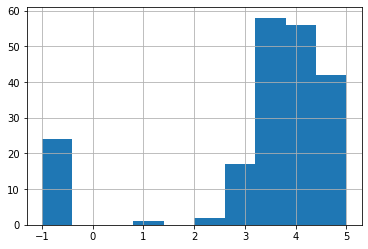

In [155]:
df.Rating.hist()

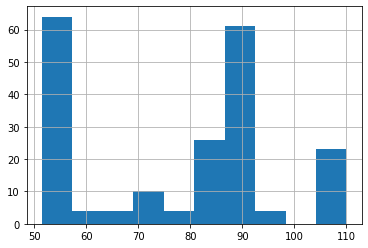

In [156]:
df.avg_salary.hist()

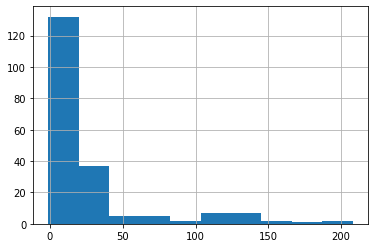

In [157]:
df.age.hist()

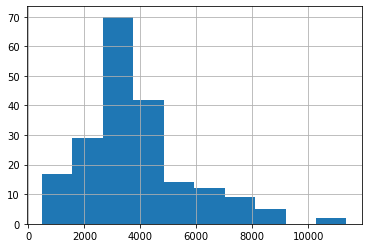

In [158]:
df.desc_len.hist()

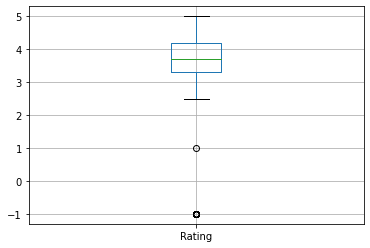

In [159]:
df.boxplot(column = 'Rating')

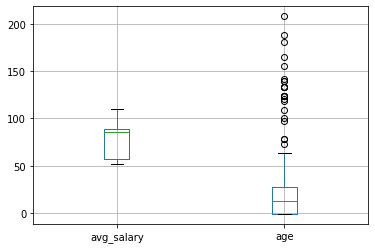

In [160]:
df.boxplot(column = ['avg_salary', 'age'])

In [161]:
df[['age','avg_salary','Rating','desc_len']].corr()

,age,avg_salary,Rating,desc_len
age,1.000000,-0.010289,0.174657,0.248627
avg_salary,-0.010289,1.000000,0.062960,-0.084088
Rating,0.174657,0.062960,1.000000,0.227095
desc_len,0.248627,-0.084088,0.227095,1.000000


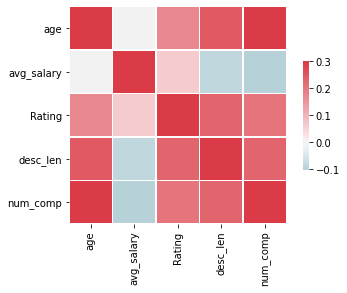

In [162]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df[['age','avg_salary','Rating','desc_len','num_comp']].corr(),vmax=.3, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [163]:
df_cat = df[['Company Name','Location','Headquarters','Size','Type of ownership','Industry','Sector','Revenue']]
df_cat2 = df[['same_city', 'python','sql','aws', 'ml','excel', 'spark', 'tableau','titles', 'seniority']]

Graph for Company Name: total = 20


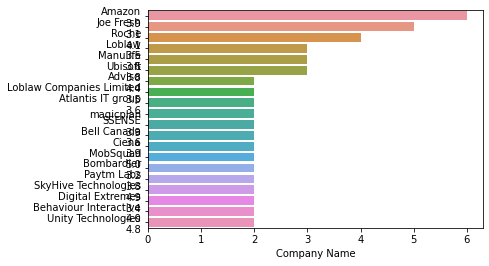

Graph for Location: total = 20


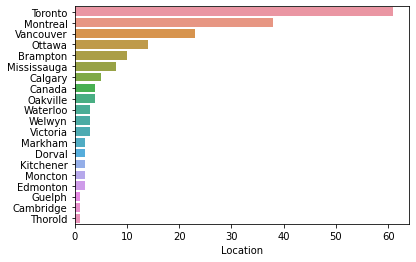

Graph for Headquarters: total = 20


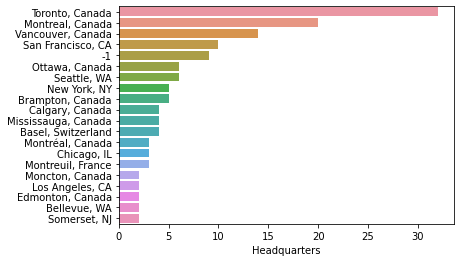

Graph for Size: total = 9


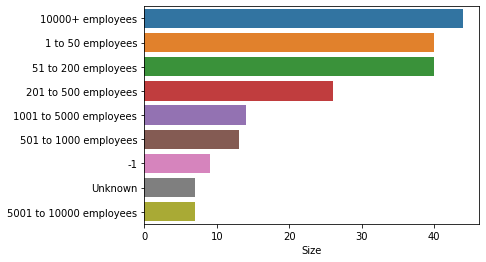

Graph for Type of ownership: total = 10


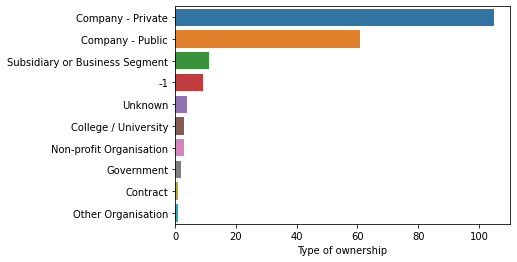

Graph for Industry: total = 20


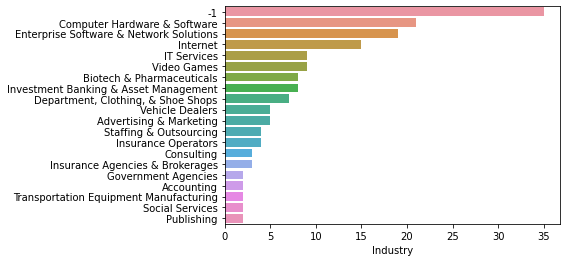

Graph for Sector: total = 20


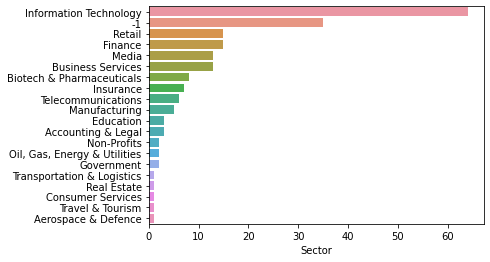

Graph for Revenue: total = 13


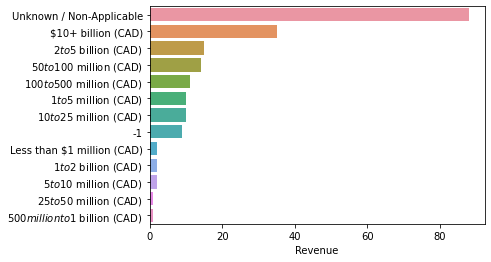

In [164]:
for i in df_cat.columns:
    cat_num = df_cat[i].value_counts()[:20]
    print("Graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num, y=cat_num.index)
    chart.set_yticklabels(chart.get_yticklabels())
    plt.show()

Graph for same_city: total = 2


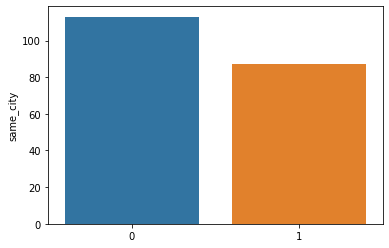

Graph for python: total = 2


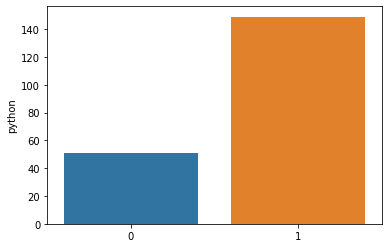

Graph for sql: total = 2


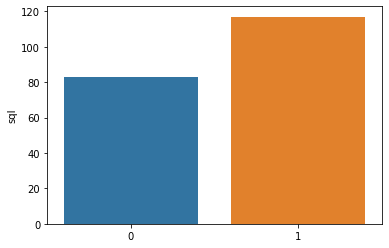

Graph for aws: total = 2


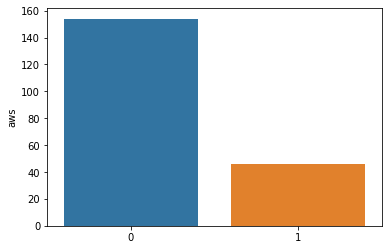

Graph for ml: total = 2


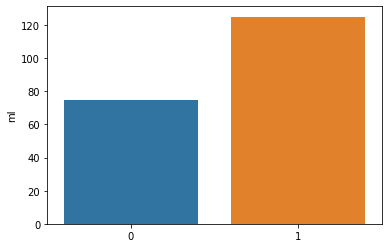

Graph for excel: total = 2


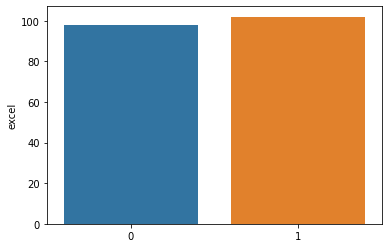

Graph for spark: total = 2


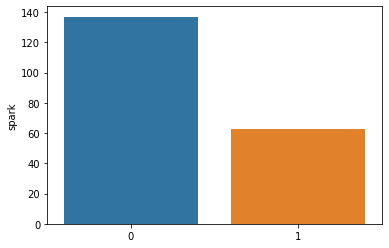

Graph for tableau: total = 2


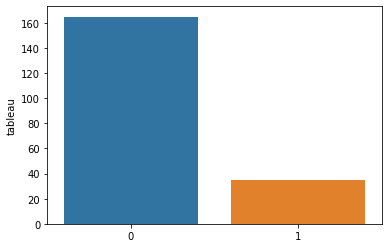

Graph for titles: total = 5


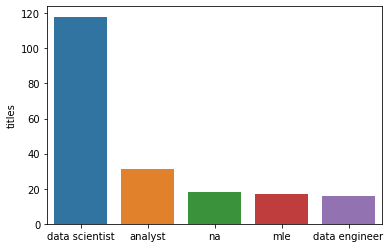

Graph for seniority: total = 3


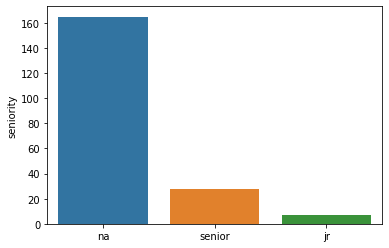

In [165]:
for i in df_cat2.columns:
    cat_num = df_cat2[i].value_counts()
    print("Graph for %s: total = %d" % (i, len(cat_num)))
    chart = sns.barplot(x=cat_num.index, y=cat_num)
    chart.set_xticklabels(chart.get_xticklabels())
    plt.show()

<br><font size = '4'>**Data distribution with pivot table**<font>

In [190]:
pd.options.display.min_rows
pd.set_option('display.max_rows', None)

In [167]:
pd.pivot_table(df, index = 'titles', values = 'avg_salary').sort_values('avg_salary', ascending = False)

,avg_salary
titles,
data scientist,80.987288
mle,75.941176
data engineer,74.875000
na,74.555556
analyst,73.112903


In [171]:
pd.pivot_table(df, index = ['titles','seniority'], values = 'avg_salary')

avg_salary
titles         seniority            
analyst        jr          89.000000
               na          72.642857
               senior      71.750000
data engineer  jr          57.000000
               na          77.535714
               senior      55.500000
data scientist jr          86.750000
               na          81.750000
               senior      77.166667
mle            na          75.941176
na             jr          72.500000
               na          73.375000
               senior      95.500000

In [175]:
pd.pivot_table(df[df.titles == 'data scientist'], index = 'Location', values = 'avg_salary').sort_values('avg_salary', ascending = False)


,avg_salary
Location,
Woodbridge,110.000000
Richmond Hill,89.000000
Victoria,89.000000
New Brunswick,89.000000
Waterloo,88.666667
Acheson,88.500000
Etobicoke,88.500000
Mississauga,88.500000
Calgary,87.833333


In [172]:
pd.pivot_table(df, index = ['Location','titles'], values = 'avg_salary').sort_values('Location', ascending = False)

avg_salary
Location      titles                    
Woodbridge    data scientist  110.000000
Winnipeg      na               57.000000
Whitby        na               66.500000
Welwyn        data scientist   74.166667
Waterloo      data scientist   88.666667
Victoria      mle              66.500000
              data scientist   89.000000
              analyst          89.000000
Vancouver     na               72.500000
              mle              62.500000
              data scientist   83.281250
              data engineer    95.500000
              analyst          65.000000
Toronto       data scientist   79.833333
              analyst          74.916667
              data engineer    80.900000
              na               66.642857
              mle              78.250000
Thorold       data scientist   86.000000
Richmond Hill data scientist   89.000000
Richmond      mle              88.500000
Ottawa        na               89.000000
              data scientist   81.772727
              data engineer    53.500000
Oakville      na               55.500000
              data scientist   87.250000
              analyst          55.500000
North York    analyst          55.500000
New Brunswick data scientist   89.000000
Montreal      na               82.750000
              mle              79.200000
              data scientist   79.195652
              data engineer    70.200000
              analyst          67.500000
Moncton       data scientist   87.250000
Mississauga   na               89.000000
              data scientist   88.500000
              analyst          80.700000
Markham       na               95.500000
              data scientist   55.500000
London        data scientist   71.500000
Kitchener     mle              83.500000
Hamilton      na              110.000000
Guelph        analyst          55.500000
Etobicoke     data scientist   88.500000
Edmonton      data scientist   86.000000
              analyst          57.000000
Dorval        data engineer    72.250000
Canada        na               75.000000
              mle              55.500000
              data scientist   87.500000
Cambridge     data engineer    95.500000
Calgary       mle              79.500000
              data scientist   87.833333
              analyst          88.500000
Brampton      data scientist   70.312500
              analyst          82.750000
Acheson       data scientist   88.500000

In [174]:
pd.pivot_table(df, index = ['Location','titles'], values = 'avg_salary', aggfunc = 'count').sort_values('Location', ascending = False)


avg_salary
Location      titles                    
Woodbridge    data scientist           1
Winnipeg      na                       1
Whitby        na                       1
Welwyn        data scientist           3
Waterloo      data scientist           3
Victoria      mle                      1
              data scientist           1
              analyst                  1
Vancouver     na                       1
              mle                      2
              data scientist          16
              data engineer            1
              analyst                  3
Toronto       data scientist          33
              analyst                 12
              data engineer            5
              na                       7
              mle                      4
Thorold       data scientist           1
Richmond Hill data scientist           1
Richmond      mle                      1
Ottawa        na                       1
              data scientist          11
              data engineer            2
Oakville      na                       1
              data scientist           2
              analyst                  1
North York    analyst                  1
New Brunswick data scientist           1
Montreal      na                       2
              mle                      5
              data scientist          23
              data engineer            5
              analyst                  3
Moncton       data scientist           2
Mississauga   na                       1
              data scientist           2
              analyst                  5
Markham       na                       1
              data scientist           1
London        data scientist           1
Kitchener     mle                      2
Hamilton      na                       1
Guelph        analyst                  1
Etobicoke     data scientist           1
Edmonton      data scientist           1
              analyst                  1
Dorval        data engineer            2
Canada        na                       1
              mle                      1
              data scientist           2
Cambridge     data engineer            1
Calgary       mle                      1
              data scientist           3
              analyst                  1
Brampton      data scientist           8
              analyst                  2
Acheson       data scientist           1

In [94]:
pd.pivot_table(df_pivots, index = 'Revenue', columns = 'python', values = 'avg_salary', aggfunc = 'count')

python,0,1
Revenue,,
$1 to $2 billion (CAD),1.0,NaN
$1 to $5 million (CAD),1.0,1.0
$10 to $25 million (CAD),2.0,2.0
$10+ billion (CAD),3.0,2.0
$100 to $500 million (CAD),6.0,1.0
$2 to $5 billion (CAD),3.0,NaN
$25 to $50 million (CAD),1.0,NaN
$50 to $100 million (CAD),1.0,NaN
-1,3.0,3.0


<br><font size = '4'>**Average salary of other categorical variables**<font>

In [177]:
df_pivots = df[['Rating', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'num_comp', 'python','sql','aws', 'ml','excel', 'spark', 'tableau','avg_salary']]


In [178]:
for i in df_pivots.columns:
    print(i)
    print(pd.pivot_table(df_pivots,index =i, values = 'avg_salary').sort_values('avg_salary', ascending = False))
    

Rating
        avg_salary
Rating            
 4.2     88.083333
 2.5     87.500000
 3.7     84.928571
 4.1     84.583333
 3.2     84.000000
 4.3     83.833333
 4.9     83.166667
 3.5     83.156250
 4.0     82.000000
 3.4     81.937500
 4.5     79.900000
 4.6     79.000000
 4.7     78.750000
 2.6     77.500000
 3.8     77.416667
 4.4     77.285714
 3.6     76.750000
 3.9     76.192308
-1.0     75.729167
 4.8     75.625000
 5.0     72.500000
 3.3     71.250000
 3.1     70.388889
 3.0     70.250000
 2.9     61.750000
 2.7     57.500000
 1.0     55.500000
Type of ownership
                                avg_salary
Type of ownership                         
Contract                         88.500000
Government                       86.000000
College / University             84.333333
-1                               82.555556
Company - Private                79.623810
Company - Public                 77.024590
Subsidiary or Business Segment   76.863636
Non-profit Organisation          66.1

ValueError: Grouper for 'avg_salary' not 1-dimensional

<br><font size = '4'>Create a word cloud.<font>

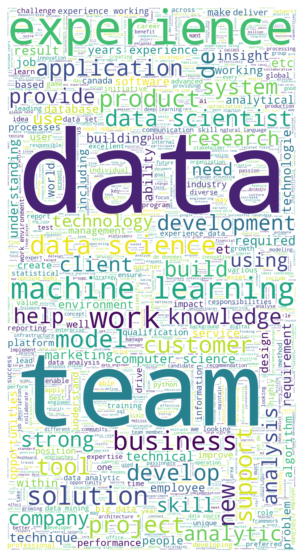

In [179]:
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

words = " ".join(df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show() #it might take 20 seconds....

# <br>Model Development

In [180]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pickle

In [181]:
df = pd.read_csv('jobs_cleaned.csv')
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp',
             'Location','same_city','age','python','sql','aws', 'ml','excel', 'spark', 'tableau','titles','seniority','desc_len']]


Split the data into train and tests sets with a test size of 20%

In [182]:
# get dummy data 
df_dum = pd.get_dummies(df_model)

# train test split 
X = df_dum.drop('avg_salary', axis =1)
y = df_dum.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<font size = '4'>**Multiple linear regression**<font>

In [183]:
# multiple linear regression with statsmodels 
X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                 -0.284
Method:                 Least Squares   F-statistic:                    0.6207
Date:                Sun, 10 May 2020   Prob (F-statistic):              0.991
Time:                        16:53:36   Log-Likelihood:                -803.49
No. Observations:                 200   AIC:                             1841.
Df Residuals:                      83   BIC:                             2227.
Df Model:                         116                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               38.8541      7.625      5.096      0.000      23.688      54.020
Rating                                               1.5533      2.457      0.632      0.529      -3.333       6.440
num_comp                                            -2.6020      3.363     -0.774      0.441      -9.290       4.086
same_city                                           -1.4184      6.816     -0.208      0.836     -14.975      12.139
age                                                 -0.1441      0.121     -1.194      0.236      -0.384       0.096
python                                              -4.6287      7.572     -0.611      0.543     -19.689      10.432
sql                                                 -0.3482      5.770     -0.060      0.952     -11.824      11.127
aws                                                  6.5401      6.480      1.009      0.316      -6.348      19.429
ml                                                   1.2551      6.091      0.206      0.837     -10.860      13.370
excel                                               -1.3314      4.774     -0.279      0.781     -10.827       8.164
spark                                                0.0204      5.579      0.004      0.997     -11.075      11.116
tableau                                              5.7544      6.809      0.845      0.400      -7.788      19.297
desc_len                                            -0.0017      0.002     -0.961      0.339      -0.005       0.002
Size_-1                                             11.6713      4.424      2.638      0.010       2.871      20.471
Size_1 to 50 employees                               3.1119      8.742      0.356      0.723     -14.276      20.500
Size_10000+ employees                                0.3081     15.749      0.020      0.984     -31.016      31.632
Size_1001 to 5000 employees                          1.0184      9.229      0.110      0.912     -17.338      19.375
Size_201 to 500 employees                           -2.8740      9.698     -0.296      0.768     -22.163      16.415
Size_5001 to 10000 employees                        17.5431     22.905      0.766      0.446     -28.015      63.101
Size_501 to 1000 employees                          -1.6426     10.517     -0.156      0.876     -22.561      19.275
Size_51 to 200 employees                            -3.4843      8.687     -0.401      0.689     -20.763      13.795
Size_Unknown                                        13.2023     14.639      0.902      0.370     -15.915      42.320
Type of ownership_-1                                11.6713      4.424      2.638      0.010       2.871      20.471
Type of ownership_College / University   

In [202]:
# multiple linear regression with sklearn
mlr = LinearRegression()
mlr.fit(X_train, y_train)
np.mean(cross_val_score(mlr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 3))

-39.80048299959096

<font size = '4'>**Lasso regression**<font>

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3059.478995788396, tolerance: 3.7365037735849067
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 976.312995626814, tolerance: 3.223716355140186
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.839345242300624, tolerance: 3.653179906542056
  positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_mod

,alpha,error
85,0.86,-16.458093


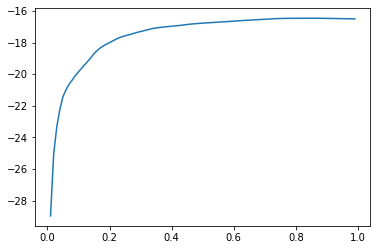

In [205]:
# Choose the best alpha value 
alpha = []
error = []

for i in range(1,100):
    alpha.append(i/100)
    lr = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 3)))
    
plt.plot(alpha,error)

err = tuple(zip(alpha,error))
df_err = pd.DataFrame(err, columns = ['alpha','error'])
df_err[df_err.error == max(df_err.error)]

Here the value of alpha should be 0.86

In [204]:
lasso_r = Lasso(alpha=.86)
lasso_r.fit(X_train,y_train)
np.mean(cross_val_score(lasso_r, X_train, y_train, scoring = 'neg_mean_absolute_error', cv= 3))

-16.458093028281017

<font size = '4'>**Random forest**<font>

In [188]:
rf = RandomForestRegressor()
np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv= 3))

-17.209902263374484

<font size = '4'>**Use GridsearchCV to reach the best model**<font>

In [198]:
# tune models GridsearchCV 
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}

gs = GridSearchCV(rf, parameters, scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train, y_train)
gs.best_score_
# this might take 5 mins....

-16.229862566969487

In [200]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

<font size = '4'>**Evaluate models using Mean Absolute Error**<font>

In [221]:
tpred_mlr = mlr.predict(X_test)
tpred_lr = lasso_r.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

# Multiple linear regression
print(mean_absolute_error(y_test,tpred_mlr))

# Lasso regression
print(mean_absolute_error(y_test,tpred_lr))

# Random forest
print(mean_absolute_error(y_test,tpred_rf))

23.502815543052254
16.430717463371366
16.06875


<font size = '4'>**Pickle the model**<font>

In [224]:
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

model.predict(np.array(list(X_test.iloc[1,:])).reshape(1,-1))[0]

list(X_test.iloc[1,:])


[2.6,
 0.0,
 1.0,
 36.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 5832.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0]